In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [4]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [5]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [20]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    
    #finding frequency of each chirp duration
    x = np.array(pd_df.CDUR)
    x = x.astype(int)
    (uniq, freq) = (np.unique(x, return_counts=True))
    xa = np.array([uniq,freq])

    #finding the bracket of 61 values with the most data points
    if (np.max(xa[0]) - np.min(xa[0])) > 60: #Checking if the range of available points exceeds interested bracket size
        jo = np.zeros(np.max(xa[0]))
        jo[xa[0]-1] = freq
        jo2 = []
        for i in range(30,len(jo)-30):
            jo2.append([i, np.sum(jo[i-30:i+30])])
        jo2 = np.array(jo2).T
        j = np.where(jo2 == np.max(jo2[1]))
        val = j[1][1] + 31

        #filtering down to values in the bracket calculated above
        x = pd_df.CDUR
        x1 = x>=(val-30)
        xa = pd_df[x1]
        x2 = xa.CDUR<=(val+30)
        xb = xa[x2]
    
    else: 
        xb = pd_df
    
    #repeating the same procedure for the values in chirp pause
    pd_df = xb
    x = np.array(pd_df.CPAU)
    x = x.astype(int)
    (uniq, freq) = (np.unique(x, return_counts=True))
    xa = np.array([uniq,freq])

    if (np.max(xa[0]) - np.min(xa[0])) > 60:
        jo = np.zeros(np.max(xa[0]))
        jo[xa[0]-1] = freq
        jo2 = []
        for i in range(30,len(jo)-30):
            jo2.append([i, np.sum(jo[i-30:i+30])])
        jo2 = np.array(jo2).T
        j = np.where(jo2 == np.max(jo2[1]))
        val = j[1][1] + 31

        x = pd_df.CPAU
        x1 = x>=(val-30)
        xa = pd_df[x1]
        x2 = xa.CPAU<=(val+30)
        xb1 = xa[x2]
    
    else: 
        xb1 = xb

    #averaging the duplicates
    dfa = pd.DataFrame([xb1.PDUR, xb1.PPAU, xb1.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    #filtering for values under the maximum duration specified
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    edg = [[0,0,0]]#, [0, dur_max, 0], [dur_max, dur_max, 0], [dur_max,0,0]] #initializing origin to zero (for smooth interpolation purposes)
    dfx = np.append(dfx, edg, axis = 0) 
    dfx = dfx.T
    
    #plotting for verifying of data points
    plt.plot(dfx[0], dfx[1], 'o')
    plt.xlim(0, dur_max)
    plt.ylim(0, dur_max)
    plt.show()
    return dfx


In [21]:
#Importing data from file

def import_data(dur_max, dur_step):

    pd_df = pd.read_csv("dat/Xls/ANU_ppf.csv")
    df = filter_data(pd_df, dur_max)
    
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = 0 #np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf


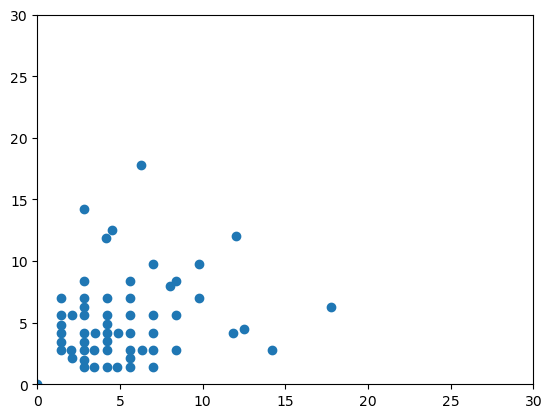

In [22]:
#defining some global variables that are constant and used throughout the code

dur_max = 30  # ms
dur_step = 0.5 # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data(dur_max, dur_step)
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

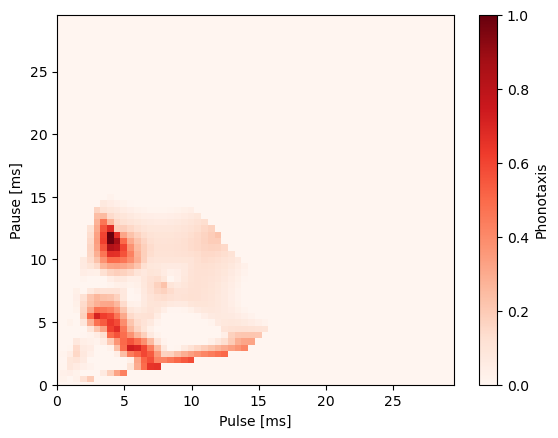

In [23]:
#For reference
plot_field(pdur_i, ppau_i, pnt_ori)

In [687]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [675]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [676]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [677]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [678]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [679]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

In [680]:
# ARM - [85, 5, 1.9, 0.07, 1.8, 12] 
# FIR - [ 2.000e+01  4.000e+01  0.000e+00 -1.741e-05 3.070e-04  1.001e+00] 
# G14 - [ 3.648e+01  1.171e+01  1.511e+00 -4.538e-02 4.306e-01  4.562e+00] 


0.1621375696505074


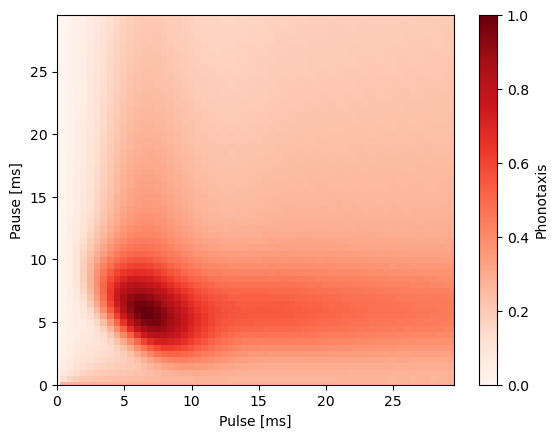

In [788]:
#setting initial values. and printing the start point of the minimize function present below
cfg = [80, 5, 0, 0.03, 0.3, 10]
y = sig_diff(cfg)
print(y)
xz = sig_diff2(cfg)
plot_field(pdur_i, ppau_i, xz[1])

In [691]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [1]:
#bounds of each parameter

b_fr = (0, 700)
b_sigma = (1, 501)
b_phi = (0, 2)
b_w = (-1, 1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  'bounds' : bnds, 
result = spo.basinhopping(sig_diff, cfg, niter = 500, minimizer_kwargs={'options' : {"disp": True }, 'bounds' : bnds,  'method' : 'L-BFGS-B'}) #stepsize = 0.9,

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.12016160419375028
                          x: [ 1.626e+01  1.514e+01  5.161e-01 -2.782e-01
                               2.934e-01  4.025e+00]
                        nit: 500
      minimization_failures: 33
                       nfev: 118587
                       njev: 16941
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.12016160419375028
                                    x: [ 1.626e+01  1.514e+01  5.161e-01
                                        -2.782e-01  2.934e-01  4.025e+00]
                                  nit: 44
                                  jac: [ 5.974e-05  1.454e-04 -2.099e-04
                                        -4.672e-04  7.425e-04

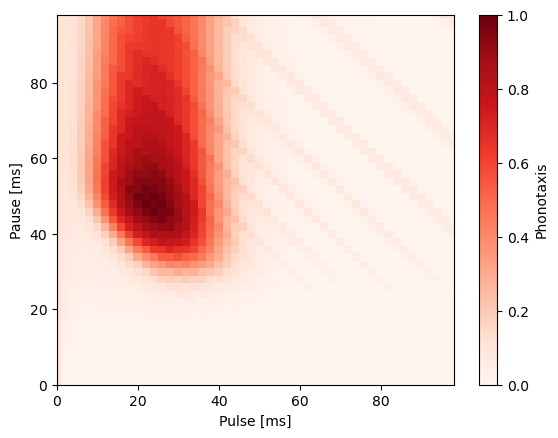

In [727]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.12016160419375028
                          x: [ 1.626e+01  1.514e+01  5.161e-01 -2.782e-01
                               2.934e-01  4.025e+00]
                        nit: 500
      minimization_failures: 33
                       nfev: 118587
                       njev: 16941
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.12016160419375028
                                    x: [ 1.626e+01  1.514e+01  5.161e-01
                                        -2.782e-01  2.934e-01  4.025e+00]
                                  nit: 44
                                  jac: [ 5.974e-05  1.454e-04 -2.099e-04
                                        -4.672e-04  7.425e-04

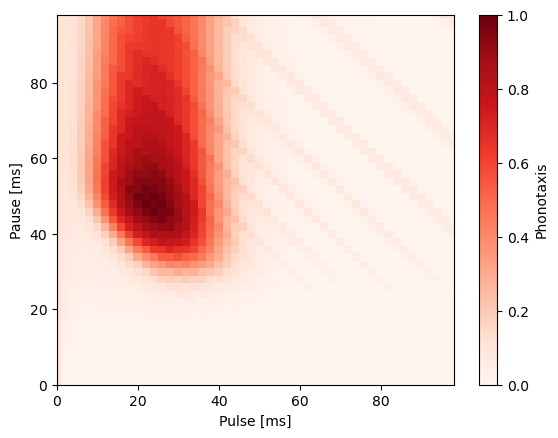

In [735]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xG13 = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xG13[1])

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.0805267217581515
                          x: [ 5.514e+01  8.674e+00  6.814e-01  1.509e-02
                               2.873e-01  1.563e+01]
                        nit: 350
      minimization_failures: 6
                       nfev: 14469
                       njev: 2067
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.0805267217581515
                                    x: [ 5.514e+01  8.674e+00  6.814e-01
                                         1.509e-02  2.873e-01  1.563e+01]
                                  nit: 101
                                  jac: [ 1.463e-06  2.642e-06 -1.180e-07
                                        -1.312e-04  3.902e-05 -1.

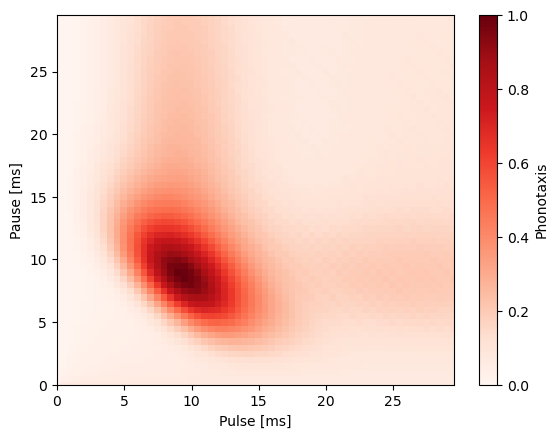

In [694]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xRUB = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xRUB[1])

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.11621807595536146
                          x: [ 7.421e+01  7.143e+00  6.085e-02  2.515e-03
                               7.567e-01  6.051e+00]
                        nit: 350
      minimization_failures: 16
                       nfev: 41510
                       njev: 5930
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.11621807595536146
                                    x: [ 7.421e+01  7.143e+00  6.085e-02
                                         2.515e-03  7.567e-01  6.051e+00]
                                  nit: 26
                                  jac: [ 9.260e-05  4.878e+03  2.700e-04
                                        -3.433e-03  2.473e-04 -

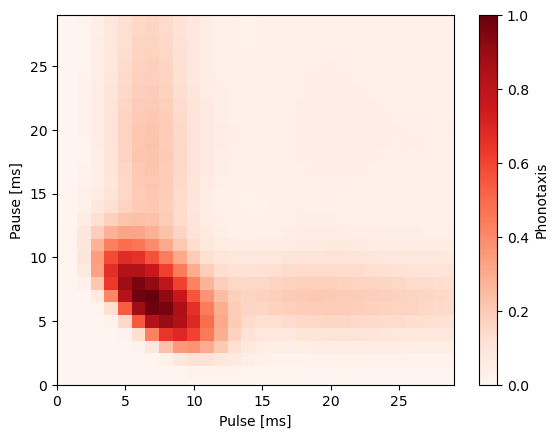

In [665]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xtex = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xtex[1])

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.090953871961382
                          x: [ 5.436e+01  1.275e+01  2.226e-06 -1.514e-05
                               1.123e-02  1.465e+00]
                        nit: 250
      minimization_failures: 9
                       nfev: 33040
                       njev: 4720
 lowest_optimization_result:  message: ABNORMAL_TERMINATION_IN_LNSRCH
                              success: False
                               status: 2
                                  fun: 0.090953871961382
                                    x: [ 5.436e+01  1.275e+01  2.226e-06
                                        -1.514e-05  1.123e-02  1.465e+00]
                                  nit: 25
                                  jac: [ 3.063e-04  5.900e-04 -1.818e-02
                                         2.549e-01 -7.076e-02 -4.836e-04]
         

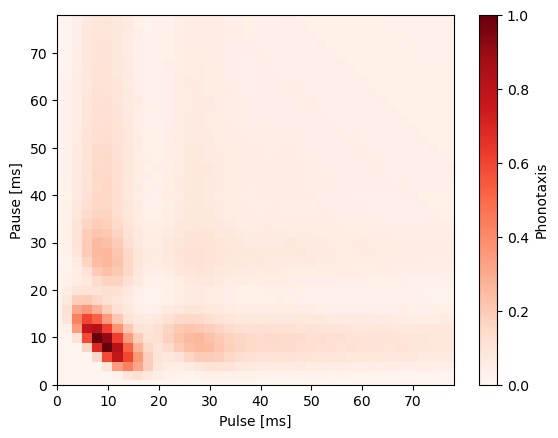

In [633]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xOAX = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xOAX[1])

128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
[0.17580477536050695, 137, 2]


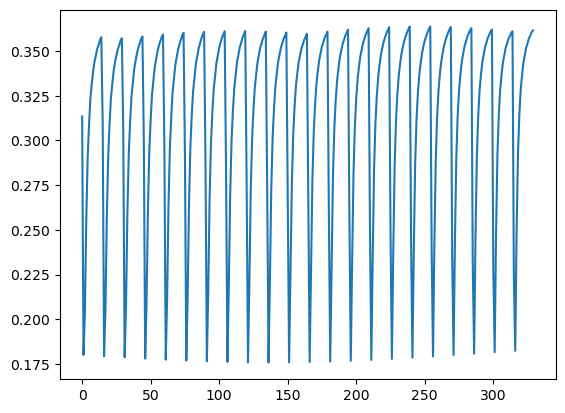

In [400]:
cfg1 = [1,0,0]
vals = []
for i in range(128, 150):
    print(i)
    for j in range(1, 16):
        cfg = [i, j, 0, 0, 0.05, 1]
        x = sig_diff(cfg)
        vals.append(x)
        if cfg1[0] > x:
            cfg1 = [x, i, j]
    
print(cfg1)
plt.plot(vals)
plt.show()